In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt


In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_data = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_data  = datasets.MNIST(root='./data', train=False, transform=transform)

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_data, batch_size=1000)


100%|██████████| 9.91M/9.91M [00:00<00:00, 22.2MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 595kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 5.52MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.84MB/s]


In [6]:
class ModelWithoutBN(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28*28, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)


In [3]:
class ModelWithoutBN(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28*28, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)


In [4]:
class ModelWithBN(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28*28, 256)
        self.bn1 = nn.BatchNorm1d(256)
        self.fc2 = nn.Linear(256, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.fc3 = nn.Linear(128, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.bn1(self.fc1(x)))
        x = F.relu(self.bn2(self.fc2(x)))
        return self.fc3(x)


In [5]:
def train(model, optimizer, criterion, loader):
    model.train()
    total_loss = 0
    correct = 0
    for data, target in loader:
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        pred = output.argmax(dim=1)
        correct += pred.eq(target).sum().item()
    return total_loss / len(loader), correct / len(loader.dataset)


In [7]:
# Create instances
modelA = ModelWithoutBN()
modelB = ModelWithBN()

optimizerA = torch.optim.Adam(modelA.parameters(), lr=0.001)
optimizerB = torch.optim.Adam(modelB.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Lists to store loss/accuracy
losses_A, accs_A = [], []
losses_B, accs_B = [], []

for epoch in range(10):
    loss_A, acc_A = train(modelA, optimizerA, criterion, train_loader)
    loss_B, acc_B = train(modelB, optimizerB, criterion, train_loader)

    losses_A.append(loss_A)
    accs_A.append(acc_A)
    losses_B.append(loss_B)
    accs_B.append(acc_B)

    print(f"Epoch {epoch+1}: NoBN Loss={loss_A:.4f}, Acc={acc_A:.4f} | WithBN Loss={loss_B:.4f}, Acc={acc_B:.4f}")


Epoch 1: NoBN Loss=0.2330, Acc=0.9305 | WithBN Loss=0.2054, Acc=0.9428
Epoch 2: NoBN Loss=0.0938, Acc=0.9706 | WithBN Loss=0.0846, Acc=0.9735
Epoch 3: NoBN Loss=0.0642, Acc=0.9797 | WithBN Loss=0.0599, Acc=0.9808
Epoch 4: NoBN Loss=0.0506, Acc=0.9839 | WithBN Loss=0.0449, Acc=0.9850
Epoch 5: NoBN Loss=0.0405, Acc=0.9867 | WithBN Loss=0.0351, Acc=0.9890
Epoch 6: NoBN Loss=0.0315, Acc=0.9895 | WithBN Loss=0.0313, Acc=0.9892
Epoch 7: NoBN Loss=0.0295, Acc=0.9901 | WithBN Loss=0.0247, Acc=0.9921
Epoch 8: NoBN Loss=0.0245, Acc=0.9917 | WithBN Loss=0.0215, Acc=0.9927
Epoch 9: NoBN Loss=0.0237, Acc=0.9921 | WithBN Loss=0.0224, Acc=0.9920
Epoch 10: NoBN Loss=0.0198, Acc=0.9933 | WithBN Loss=0.0180, Acc=0.9941


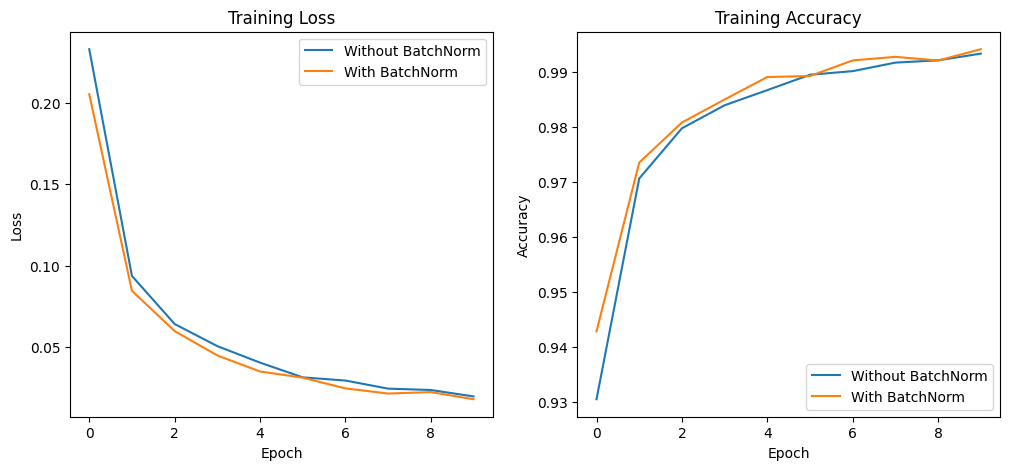

In [8]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(losses_A, label="Without BatchNorm")
plt.plot(losses_B, label="With BatchNorm")
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(accs_A, label="Without BatchNorm")
plt.plot(accs_B, label="With BatchNorm")
plt.title("Training Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.show()


In [9]:
def evaluate(model, loader):
    model.eval()
    correct = 0
    with torch.no_grad():
        for data, target in loader:
            output = model(data)
            pred = output.argmax(dim=1)
            correct += pred.eq(target).sum().item()
    return correct / len(loader.dataset)

print("Test Accuracy (NoBN):", evaluate(modelA, test_loader))
print("Test Accuracy (WithBN):", evaluate(modelB, test_loader))


Test Accuracy (NoBN): 0.9798
Test Accuracy (WithBN): 0.9811
